# UDF (User Defined Function)
Spark SQL 関数を使えば多くの解析ができることが分かった。<br>
自動的に最適化やGPUの使用などが可能となるため、極力これらを使用して解析を完結させたいが、<br>
どうしても自前の関数をプログラムしたい場合、UDFを使うことになる。

pysparkを使う場合、主にpyspark UDF、pandas UDF、scala UDFを使うことになるのでそれぞれ例とともに紹介する。
## pyspark UDF
- pyspark.sql.functions.udf(): python関数をユーザー関数として登録する。各行に対してpython関数が呼ばれる。

spark SQLにないpythonの関数を手軽に使うことができる。
以下はポアソン分布の例。

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

df = spark.read.parquet("./data/clover_data.parquet").filter("ch==0").select("ts")
df.show(5)

+-------------+
|           ts|
+-------------+
|7296322069363|
|7296322439661|
|7296324338282|
|7296325482656|
|7296325659242|
+-------------+
only showing top 5 rows


このデータは検出器1チャンネル分のヒット時刻情報である。<br>

In [39]:
TWINDOW = 2000000 # 20 ms
count = df.count() # トータルイベント数
t = df.select(F.max("ts")).collect()[0][0]-df.select(F.min("ts")).collect()[0][0] # データ収集時間 (ns)
n = count/t*TWINDOW # 20ms当たりの平均イベント数
print(n)

3.720139207327362


20 ms当たり3.7イベントのレートでデータが存在する。<br>
実際のデータがポアソン分布に従っているか確認するため、ポアソン分布乱数を生成するUDFを定義する。<br>
`def poisson():` で定義した関数に対して、F.udf(poisson, 戻り値の型)でUDFを定義できる。<br>
このUDFはspark SQLで列として使うことができる。

In [49]:
import numpy as np
from pyspark.sql.types import IntegerType
# python 関数の定義
def poisson():
    return np.random.poisson(n)

# pyspark UDFの定義
poisson_udf = F.udf(poisson, IntegerType())

from pyspark.sql.window import Window
w = Window.orderBy("ts").rangeBetween(0,TWINDOW)
df = df.withColumn("events_in_20ms", F.count("ts").over(w)) \
       .withColumn("poisson", poisson_udf())
df.show(10)

25/10/10 16:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 16:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 16:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 16:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 16:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------+--------------+-------+
|           ts|events_in_20ms|poisson|
+-------------+--------------+-------+
|7296322069363|             2|      8|
|7296322439661|             2|      7|
|7296324338282|             5|      1|
|7296325482656|             7|      3|
|7296325659242|             8|      3|
|7296325848896|             7|      2|
|7296326186842|             6|      9|
|7296327141309|             6|      7|
|7296327246553|             5|      4|
|7296327385651|             5|      3|
+-------------+--------------+-------+
only showing top 10 rows


しかし、実際のデータと乱数を両方プロットしてみると、分布が大きく異なることが分かる。

25/10/10 15:43:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:43:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:43:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:43:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Total entries: 75254, Underflow: 0, Inside: 74278, Overflow: 976
Total entries: 75254, Underflow: 0, Inside: 74855, Overflow: 399


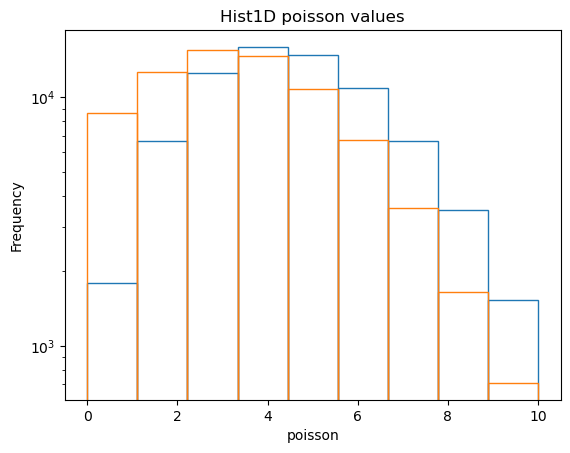

In [47]:
from hist.sparkHist1d import Hist1D
from matplotlib import pyplot as plt

Hist1D(df, "events_in_20ms",10,[0,10],facecolor="none",edgecolor="tab:blue")
Hist1D(df, "poisson",10,[0,10],facecolor="none",edgecolor="tab:orange")
plt.yscale("log")

これは、検出器の立下り部分の信号にリンギングなどのゆらぎが発生することによって、<br>
ランダムではないデータが含まれているという可能性がある。<br>
そこで、Window定義を信号の直後ではなく、しばらく後にずらしてみる。

25/10/10 15:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/10/10 15:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Total entries: 75254, Underflow: 0, Inside: 74912, Overflow: 342
Total entries: 75254, Underflow: 0, Inside: 74840, Overflow: 414


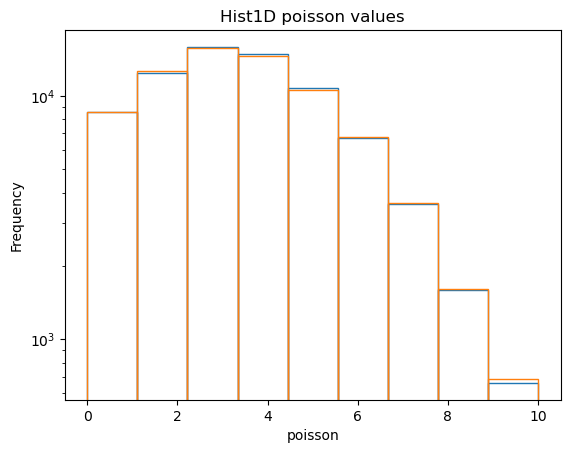

In [48]:
OFFSET = 100000000 # 100 ms
w = Window.orderBy("ts").rangeBetween(OFFSET,OFFSET+TWINDOW)
df = df.withColumn("events_in_20ms", F.count("ts").over(w)) \
       .withColumn("poisson", poisson_udf())

Hist1D(df, "events_in_20ms",10,[0,10],facecolor="none",edgecolor="tab:blue")
Hist1D(df, "poisson",10,[0,10],facecolor="none",edgecolor="tab:orange")
plt.yscale("log")

充分離れた時間ウィンドウのイベント数はポアソン分布に従っていることが分かる。